Notebook presenting basic rejection sampling and Gillespie algorithms for simulating an SIR process in a mean field population.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64

In [2]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x000002C501813EB0>


# Functions 

In [3]:

def rejection_sampling_SIR_MF(beta_k, mu, dt, T, S, I, R):
    '''
    Simulates the mean field SIR process using rejection sampling.
    
    --- Input: ---
    beta_k : mean-field infection rate for an S-I pair of individuals, beta_k = beta * k / N
    mu     : recovery rate of an infectious individual
    dt     : time step of simulations
    T      : temporal length of simulation
    S      : initial number of susceptible individuals
    I      : initial number of infectious individuals
    R      : initial number of recovered individuals
    
    --- Outputs: ---
    X_t : numpy array of numbers of susceptible, infectious, and recovered individuals at discrete points in time, 
          X_t[n] = [n * dt, S, I, R]
    '''

    #--- Vector to save temporal evolution over time: ---
    X_t = []
    X_t.append([0., S, I, R])

    for i in range(int(T / dt)):
        #--- Infection and recovery probabilites in single time step: ---
        p_inf = S * I * beta_k * dt
        p_rec = I * mu * dt

        # Check if transition probabilities sum to zero (no more reactions can happen):
        if np.isclose(p_inf + p_rec, 0.):
            # Save final state and break loop:
            X_t.append([T, S, I, R])
            break

        #--- Rejection sampling step: ---
        # Draw two uniform random variates (for each possible reaction):
        u1, u2 = rg.random(2)
        
        # Check if an S->I reaction takes place:
        if u1 < p_inf:
            S -= 1
            I += 1
        # Check if an I->R reaction takes place:
        if u2 < p_rec:
            I -= 1
            R += 1

        #--- Save current state to X_t: ---
        X_t.append([(i + 1) * dt, S, I, R])
        
    return(np.array(X_t).transpose())

##################################################################################################
##################################################################################################

def Gillespie_SIR_MF(beta_k, mu, T, S, I, R, method='direct'):
    '''
    Simulates the mean field SIR process using Gillespie's direct or first reaction method.
    
    --- Input: ---
    beta_k : mean-field infection rate for an S-I pair of individuals, beta_k = beta * k / N
    mu     : recovery rate of an infectious individual
    T      : temporal length of simulation
    S      : initial number of susceptible individuals
    I      : initial number of infectious individuals
    R      : initial number of recovered individuals
    
    --- Outputs: ---
    X_t : numpy array of numbers of susceptible, infectious, and recovered individuals at each point in time, 
          X_t[n] = [t_n, S, I, R]
    '''
    
    # Initialize time to zero:
    t = 0
    # List to save temporal evolution of system: 
    X_t = [] 

    while t < T:
        # Save current state to X_t:
        X_t.append([t, S, I, R])

        # Update infection and recovery rates: 
        a_inf = S * I * beta_k # Infection rate
        a_rec = I * mu         # Recovery rate

        # Check if a_inf+a_rec==0 (no more reactions happen):
        if np.isclose(a_inf + a_rec, 0.): 
            t = T # Set time to T
            break # Break loop

        # Check if a_rec==0 (only recovery may take place):
        elif np.isclose(a_inf, 0.): 
            i_selected = 1
            tau = - np.log(1. - rg.random()) / a_rec

        # Else, draw next event and waiting time:
        else:
            if method=='direct':
                i_selected, tau = draw_next_event_direct(a_inf, a_rec)
            elif method=='first_reaction':
                i_selected, tau = draw_next_event_first_reaction(a_inf, a_rec)
            else:
                raise Exception("method should be 'direct or 'first_reaction'.")

        # Update state:
        if i_selected == 0: # S->I reaction
            S -= 1
            I += 1
        else:               # I->R reaction
            I -= 1
            R += 1

        # Update time:
        t += tau

    # Save final state to X_t:
    X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose())

##################################################################################################
##################################################################################################

def draw_next_event_first_reaction(a_inf, a_rec):
    '''
    --- Input: ---
    a_inf : cumulative infection rate of susceptible individuals. 
    a_rec : cumulative recovery rate of infectious individuals. 
    
    --- Outputs: ---
    i_selected : selected reaction channel (event type).
    tau_min : waiting time between events.
    '''

    # Draw a uniform random variate for each waiting time:
    u = 1. - rg.random(2)

    # Draw waiting times:
    taus = - np.log(u) / np.array([a_inf, a_rec])

    # Select reaction with minimal tau:
    tau_min    = np.min(taus)
    i_selected = np.argmin(taus)
        
    return(i_selected, tau_min)

##################################################################################################
##################################################################################################

def draw_next_event_direct(a_inf, a_rec):
    '''
    --- Input: ---
    a_inf : cumulative infection rate of susceptible individuals. 
    a_rec : cumulative recovery rate of infectious individuals. 
    
    --- Outputs: ---
    i_selected : selected reaction channel (event type).
    tau : waiting time between events.
    '''

    # Calculate cumulative rate:
    a_sum = a_inf + a_rec  

    # Draw two uniform random variates on (0,1]:
    u1, u2 = 1. - rg.random(2)

    # Draw waiting time:
    tau = - np.log(u1) / a_sum 

    # Select reaction and update state:
    if u2 * a_sum < a_inf: # S->I reaction
        i_selected = 0
    else:                  # I->R reaction
        i_selected = 1

    return(i_selected, tau)

##################################################################################################
##################################################################################################


# Simulations

## Rejection sampling grouped by reaction type
Two reaction channels: 1) for an infection between of any S individual and 2) for a recovery of any infectious individual.

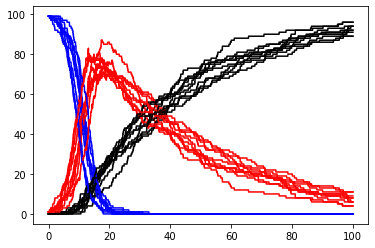

In [4]:
#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration
dt     = 0.01  # Time step length

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(rejection_sampling_SIR_MF(beta_k, mu, dt, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

## Direct method
One reaction channel for each S individual (infection) and each I individual (recovery).

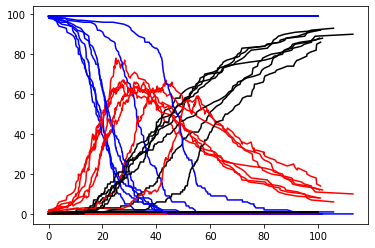

In [5]:
#--- Simulation parameters: ---
beta   = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(Gillespie_SIR_MF(beta_k, mu, T, S0, I0, R0, 'direct'))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

## First reaction method

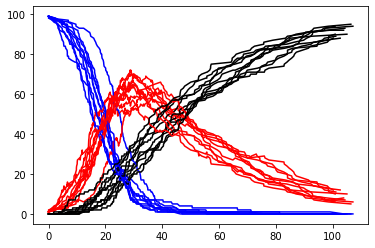

In [6]:

#--- Simulation parameters: ---
beta   = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(Gillespie_SIR_MF(beta_k, mu, T, S0, I0, R0, 'first_reaction'))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

# Speed comparison 

## Rejection sampling 

In [7]:
%timeit rejection_sampling_SIR_MF(beta_k, mu, dt, T, S0, I0, R0)

The slowest run took 46.42 times longer than the fastest. This could mean that an intermediate result is being cached.
793 ms ± 324 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Direct method 

In [8]:
%timeit Gillespie_SIR_MF(beta_k, mu, T, S0, I0, R0, 'direct')

36.4 ms ± 6.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## First reaction method 

In [9]:
%timeit Gillespie_SIR_MF(beta_k, mu, T, S0, I0, R0, 'first_reaction')

33.6 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
